# Autoencoders
## Credit card fraud detection, an anomaly detection problem
<br>

This notebook presents an example of an anomaly detection problem where we use autoencoders to solve it. This notebook is baed on the following sources, specially on the article "Credit card fraud detection using autoencoders in H2O".


__Sources__: <br>
https://towardsdatascience.com/credit-card-fraud-detection-using-autoencoders-in-h2o-399cbb7ae4f1 <br>
https://medium.com/@curiousily/credit-card-fraud-detection-using-autoencoders-in-keras-tensorflow-for-hackers-part-vii-20e0c85301bd <br>
https://blog.keras.io/building-autoencoders-in-keras.html <br>
http://ufldl.stanford.edu/tutorial/unsupervised/Autoencoders/ <br>
https://www.youtube.com/watch?time_continue=1&v=FzS3tMl4Nsc

## Autoencoders
Autoencoders is an unsupervised Neural Network. It is a data compression algorithm which takes the input and going through a compressed representation and gives the reconstructed output. 
<br> <br>
Autoencoders can seem quite bizarre at first. The job of those models is to predict the input, given that same input. Puzzling? Definitely was for me, the first time I heard it.
More specifically, let’s take a look at Autoencoder Neural Networks. This Autoencoder tries to learn to approximate the following identity function: $f_{W,b}(x)\sim x$

While trying to do just that might sound trivial at first, it is important to note that we want to learn a compressed representation of the data, thus find structure. This can be done by limiting the number of hidden units in the model. Those kind of autoencoders are called undercomplete.
<br><br>
Here’s a visual representation of what an Autoencoder might learn:
<img src = "Files/autoencoder_mushroom.png" width="600">

## Reconstruction error
We optimize the parameters of our Autoencoder model in such way that a special kind of error — reconstruction error is minimized. In practice, the traditional squared error is often used:
<br>
$L(x',x)=\lVert \mathbf{x-x'} \rVert^2$

We are going to use a dataset from Kaggle, where we have 284,807 transactions. Among them, 492 transactions are labeled as frauds. Download the dataset from: https://www.kaggle.com/mlg-ulb/creditcardfraud

In [2]:
import h2o
import matplotlib.pyplot as plt
from pylab import rcParams
import numpy as np 
import pandas as pd 
import os
from h2o.estimators.deeplearning import H2OAutoEncoderEstimator, H2ODeepLearningEstimator

In [3]:
h2o.init(max_mem_size = 2)
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM (build 25.152-b12, mixed mode)56-b12)
  Starting server from C:\Users\a.nogue.sanchez\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\ANOGUE~1.SAN\AppData\Local\Temp\tmpfaf_nft9
  JVM stdout: C:\Users\ANOGUE~1.SAN\AppData\Local\Temp\tmpfaf_nft9\h2o_a_nogue_sanchez_started_from_python.out
  JVM stderr: C:\Users\ANOGUE~1.SAN\AppData\Local\Temp\tmpfaf_nft9\h2o_a_nogue_sanchez_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,04 secs
H2O cluster timezone:,Europe/Paris
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.1
H2O cluster version age:,4 months and 15 days !!!
H2O cluster name:,H2O_from_python_a_nogue_sanchez_5h3fkj
H2O cluster total nodes:,1
H2O cluster free memory:,1.778 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


## The dataset
Load the data as a pandas data frame.

The dataset contains 31 features: time (the time elapsed between transactions in the dataset), amount (the transaction amount), class (whether it is a fraud transaction: 1 means fraud) and 28 features are the 28 principal components obtained with PCA from the original dataset.

In [31]:
# Download the dataset and save it in the "Files" foldes
creditData = pd.read_csv(r"Files\creditcard.csv") 
creditData.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
creditData.shape # Dimensionality & number of observations

(284807, 31)

In [6]:
creditData.isnull().values.any() # Missing values? No

False

Parse progress: |█████████████████████████████████████████████████████████| 100%


Text(0, 0.5, 'Frequency')

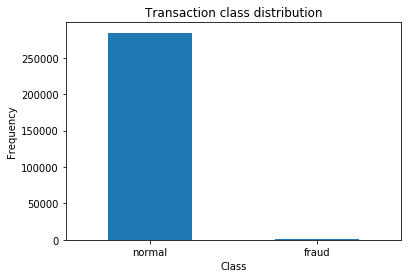

In [7]:
creditData_h2o  = h2o.H2OFrame(creditData)
# Let’s plot the Transaction class against the Frequency
labels = ['normal','fraud']
classes = pd.value_counts(creditData['Class'], sort = True)
classes.plot(kind = 'bar', rot = 0)
plt.title('Transaction class distribution')
plt.xticks(range(2), labels)
plt.xlabel('Class')
plt.ylabel('Frequency')

We can drop the Time variable as it is not giving impact on the model prediction

In [8]:
features = creditData_h2o.drop(['Time'], axis=1)

Split into train and test set

In [10]:
train, test = features.split_frame([0.8], seed = 62)
print(train.shape)
print(test.shape)

(228081, 30)
(56726, 30)


Training our Autoencoder is going to be a bit different from what we are used to. Let’s say you have a dataset containing a lot of non fraudulent transactions at hand. You want to detect any anomaly on new transactions. We will create this situation by training our model on the normal transactions, only. Reserving the correct class on the test set will give us a way to evaluate the performance of our model.

In [11]:
# converting to pandas dataframe
train_df = train.as_data_frame()
test_df = test.as_data_frame()

train_df = train_df[train_df['Class'] == 0]
train_df = train_df.drop(['Class'], axis = 1) # drop the Class variable

Y_test_df = test_df['Class'] # true labels of the testing set
test_df = test_df.drop(['Class'], axis=1)
train_df.shape

(227683, 29)

## Model

In [12]:
train_h2o = h2o.H2OFrame(train_df) # converting to h2o frame
test_h2o = h2o.H2OFrame(test_df)
x = train_h2o.columns

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


When building the model, 4 fully connected hidden layers were chosen with, [14,7,7,14] number of nodes for each layer. First two for the __encoder__ and last two for the __decoder__.

In [13]:
anomaly_model = H2ODeepLearningEstimator(activation = "Tanh",
                                hidden = [14,7,7,14],
                                epochs = 100,
                                standardize = True,
                                stopping_metric = 'MSE', 
                                loss = 'automatic',
                                train_samples_per_iteration = 32,
                                shuffle_training_data = True,     
                                autoencoder = True,
                                l1 = 10e-5)
%time anomaly_model.train(x = x, training_frame = train_h2o)

deeplearning Model Build progress: |██████████████████████████████████████| 100%
Wall time: 1min 30s


In [17]:
anomaly_model._model_json['output']['variable_importances'].as_data_frame()

,variable,relative_importance,scaled_importance,percentage
0,V18,1.000000,1.000000,0.143555
1,V13,0.997641,0.997641,0.143217
2,V26,0.994122,0.994122,0.142711
3,V11,0.991239,0.991239,0.142298
4,V24,0.990671,0.990671,0.142216
5,V4,0.986011,0.986011,0.141547
6,V15,0.964564,0.964564,0.138468
7,V19,0.010819,0.010819,0.001553
8,V12,0.008668,0.008668,0.001244
9,V22,0.005695,0.005695,0.000818


The testing set has both normal and fraud transactions in it. The Autoencoder will learn to identify the pattern of the input data. If an anomalous test point does not match the learned pattern, the autoencoder will likely have a high error rate in reconstructing this data, indicating anomalous data. So that we can identify the anomalies of the data. To calculate the error, it uses Mean Squared Error (MSE).

Predictions on the test data:

In [18]:
# predicting the class for the testing dataset
test_rec_error = anomaly_model.anomaly(test_h2o) 
# anomaly is a H2O function which calculates the error for the dataset
# converting to pandas dataframe
test_rec_error_df = test_rec_error.as_data_frame()

# plotting the testing dataset against the error
test_rec_error_df['id'] = test_rec_error_df.index
predictions = anomaly_model.predict(test_h2o)
error_df = pd.DataFrame({'reconstruction_error': test_rec_error_df['Reconstruction.MSE'],
                        'true_class': Y_test_df})
error_df.describe()

deeplearning prediction progress: |███████████████████████████████████████| 100%


,reconstruction_error,true_class
count,56726.000000,56726.000000
mean,0.000629,0.001657
std,0.001508,0.040674
min,0.000040,0.000000
25%,0.000249,0.000000
50%,0.000401,0.000000
75%,0.000680,0.000000
max,0.079472,1.000000


ROC Curve:

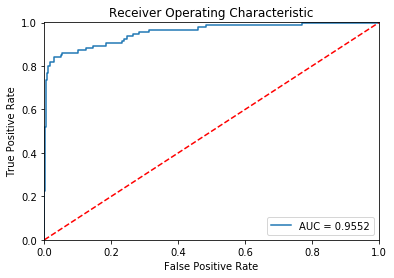

In [19]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Precision and recall

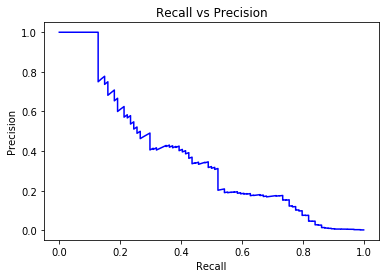

In [20]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

We need to find a better threshold that can separate the anomalies from normal. This can be done by calculating the intersection of the Precision/Recall vs Threshold graph.

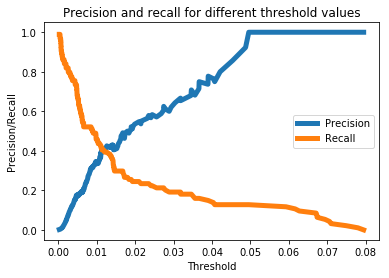

In [21]:
plt.plot(th, precision[1:], label="Precision",linewidth=5)
plt.plot(th, recall[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

Plot the predictions with the new threshold

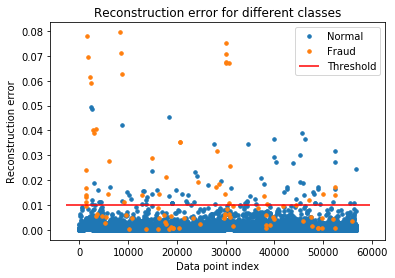

In [22]:
# plot the testing set with the threshold
threshold = 0.01
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

Confusion matrix

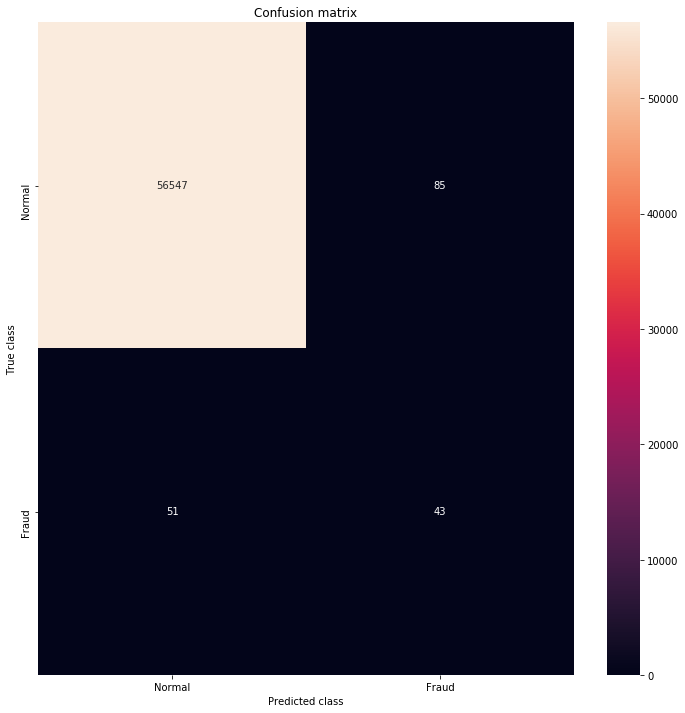

In [28]:
import seaborn as sns
LABELS = ['Normal', 'Fraud']
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

Classification report

In [30]:
csr = classification_report(error_df.true_class, y_pred)
print(csr)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56632
           1       0.34      0.46      0.39        94

   micro avg       1.00      1.00      1.00     56726
   macro avg       0.67      0.73      0.69     56726
weighted avg       1.00      1.00      1.00     56726

